![image.png](https://i.imgur.com/a3uAqnb.png)

# Bidirectional Arabic-English Translation using mBART
- **Model**: Facebook's mBART-large-50-one-to-many-mmt pre-trained transformer
- **Languages**: Arabic (ar_AR) ↔ English (en_XX) bidirectional translation
- **Dataset**: Classic Arabic-English Language Pairs from HuggingFace
- **Approach**: Fine-tuning with data augmentation (random language swapping)

![mBART Architecture](https://i.imgur.com/n8WXfHG.png)

## **🔹 What is mBART?**
**mBART** (Multilingual Bidirectional Auto-Regressive Transformer) is a sequence-to-sequence model pre-trained on 50+ languages. It's particularly effective for:
- **Machine Translation** between multiple language pairs
- **Cross-lingual understanding** using shared representations
- **Few-shot learning** on new language pairs

## 📦 Package Installation & Setup
Installing required packages for transformer fine-tuning and evaluation.

In [1]:
from IPython.display import clear_output

In [2]:
# Essential packages for transformer fine-tuning
# %pip install gdown          # For downloading datasets from Google Drive
# %pip install evaluate       # For computing BLEU scores
# %pip install pandas         # For data manipulation
# %pip install sentencepiece  # Required for mBART tokenizer
# %pip install accelerate     # For distributed training support
# %pip install protobuf==3.20.3  # Specific version to avoid conflicts
# %pip install matplotlib     # For plotting training curves
# %pip install transformers datasets  # HuggingFace transformers and datasets
# %pip install torch torchdata --quiet  # PyTorch framework
# %pip install tqdm          # Progress bars for training loops
# %pip install scikit-learn  # For train-test splitting

clear_output()  # Clear installation output for cleaner notebook

## 🔧 Import Required Libraries
Loading all necessary libraries for data processing, model training, and evaluation.

In [3]:
# Core libraries
import math
import random
import json

# Data handling and processing
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# HuggingFace transformers
from transformers import (
    GenerationConfig,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    MBartForConditionalGeneration,
    MBart50TokenizerFast,
    MBart50Tokenizer
)

# PyTorch
import torch

# Evaluation and visualization
import evaluate
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
random.seed(7)
torch.manual_seed(7)

## 🗂️ Dataset Loading and Exploration

We'll use the **Classic Arabic-English Language Pairs** dataset, which contains:
- **Arabic sentences** (Classical Arabic text)
- **English translations** (Modern English equivalents)
- **Domain**: Religious and classical texts

### Dataset Structure
- **Source**: HuggingFace datasets
- **Split**: Books collection with paired sentences
- **Format**: Each row contains Arabic and English sentence pairs

In [4]:
from datasets import load_dataset

# Load the Arabic-English translation dataset
# This dataset contains classical Arabic texts with English translations
dataset = load_dataset("Abdulmohsena/Classic-Arabic-English-Language-Pairs")

print("📊 Dataset Information:")
print(f"Dataset keys: {list(dataset.keys())}")
print(f"Number of examples: {len(dataset['books'])}")

📊 Dataset Information:
Dataset keys: ['quran', 'hadith', 'books']
Number of examples: 13331


In [5]:
# Explore the dataset structure
print("🔍 Dataset Structure:")
print(dataset)

# Check the first few examples to understand the data format
sample_data = dataset['books'][:3]
print("\n📝 Sample Data:")
for i, example in enumerate(sample_data['en'][:3]):
    print(f"\nExample {i+1}:")
    print(f"English: {example}")
    print(f"Arabic: {sample_data['ar'][i]}")

🔍 Dataset Structure:
DatasetDict({
    quran: Dataset({
        features: ['ar', 'en'],
        num_rows: 9474
    })
    hadith: Dataset({
        features: ['ar', 'en'],
        num_rows: 4107
    })
    books: Dataset({
        features: ['ar', 'en'],
        num_rows: 13331
    })
})

📝 Sample Data:

Example 1:
English: [Chapter on entering upon kings] [Entering of the nobles] If the one entering is from the nobles and the high class, then it is the right of the king to stand in a place where he is not far from him, nor close to him, and to greet him while standing.
Arabic: [باب في الدخول على الملوك] [دخول الأشراف] إن كان الداخل من الأشراف والطبقة العالية، فمن حق الملك أن يقف منه بالموضع الذي لا ينأى عنه، ولا يقرب منه، وأن يسلم عليه قائما.

Example 2:
English: If he approached him, he would come close to him, lean on his limbs and kiss them, then move away from him and stand until he stands at a level like his.
Arabic: فإن استدناه، قرب منه، فأكب على أطرافه يقبلها، ثم تنحى عنه قائما

In [6]:
# Set random seed for reproducibility
random.seed(7)

# Check for GPU availability and set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️ Using device: {device}")

# Display GPU information if available
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🖥️ Using device: cuda
GPU Name: Tesla V100-SXM2-32GB
GPU Memory: 34.1 GB


## 🔄 Data Preprocessing and Splitting

We'll prepare the data for training by:
1. **Converting** HuggingFace dataset to pandas DataFrame
2. **Splitting** into train/test sets (80/20 split)
3. **Limiting** dataset size for efficient training (5K train, 1K test)
4. **Creating** HuggingFace Dataset objects for the Trainer API

In [7]:
from sklearn.model_selection import train_test_split

# Convert HuggingFace dataset to pandas DataFrame for easier manipulation
train_data = pd.DataFrame(dataset['books'])

# Split data into train and test sets (80/20 split)
train_data_full, test_data = train_test_split(
    train_data, 
    test_size=0.2, 
    random_state=42
)

# Limit dataset size for efficient training
# Using smaller subsets to reduce training time while maintaining quality
train_data = train_data_full.head(5000)  # 5K training examples
test_data = test_data.head(1000)         # 1K testing examples

print(f"📊 Dataset Sizes:")
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Total examples: {len(train_data) + len(test_data)}")

📊 Dataset Sizes:
Training data shape: (5000, 2)
Testing data shape: (1000, 2)
Total examples: 6000


In [8]:
# Display sample of the training data to verify structure
print("📋 Sample Training Data:")
display(train_data.head())

# Check for any missing values
print(f"\n🔍 Missing Values Check:")
print(f"English missing: {train_data['en'].isnull().sum()}")
print(f"Arabic missing: {train_data['ar'].isnull().sum()}")

📋 Sample Training Data:


,ar,en
9689,ولما عقل نفسه كان عاقلا، ولما كان نفسه معقولا ...,"And since he understood himself, he was ration..."
7436,من ذلك قولهم: ضربه على أم رأسه، وكذلك أم الهاوية.,This includes their saying: He hit him on the ...
1082,لأن هذه الأقسام الثلاثة أكثر ما تقع وتتفق بسؤا...,Because these three sections most often occur ...
1671,ولكني أسألك أيها الملك حاجة تسعفني بها، وتعطين...,"But I ask you, O King, for a need that you may..."
12394,قوله: وأتت العضل العريضة الحنجرية التي رؤوسها ...,His saying: “And the broad laryngeal muscles w...



🔍 Missing Values Check:
English missing: 0
Arabic missing: 0


In [9]:
# Convert pandas DataFrames to HuggingFace Dataset objects
# This format is required for the HuggingFace Trainer API
train_dataset = Dataset.from_pandas(train_data, split='train')
test_dataset = Dataset.from_pandas(test_data, split='test')

print(f"✅ Created HuggingFace Datasets:")
print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

✅ Created HuggingFace Datasets:
Train dataset: Dataset({
    features: ['ar', 'en', '__index_level_0__'],
    num_rows: 5000
})
Test dataset: Dataset({
    features: ['ar', 'en', '__index_level_0__'],
    num_rows: 1000
})


## 🤖 Model and Tokenizer Setup

### Loading Pre-trained mBART Model
- **Model**: `facebook/mbart-large-50-one-to-many-mmt`
- **Languages Supported**: 50+ languages including Arabic and English
- **Architecture**: Encoder-decoder transformer optimized for translation
- **Pre-training**: Multilingual denoising autoencoder training

### Language Codes Used:
- **English**: `en_XX`
- **Arabic**: `ar_AR`

In [10]:
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

# Load pre-trained mBART model and tokenizer
# Using the one-to-many variant which is more efficient for bidirectional translation
model_name = 'facebook/mbart-large-50-one-to-many-mmt'

print("🔄 Loading pre-trained mBART model...")
model = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer = MBart50Tokenizer.from_pretrained(model_name)

print(f"✅ Model loaded successfully!")
print(f"Model parameters: {model.num_parameters():,}")
print(f"Tokenizer vocabulary size: {len(tokenizer)}")

🔄 Loading pre-trained mBART model...
✅ Model loaded successfully!
Model parameters: 610,879,488
Tokenizer vocabulary size: 250054


## 🔤 Tokenization and Data Augmentation

### Key Components:
1. **Language Code Mapping**: Convert `en`/`ar` to mBART tokens (`en_XX`/`ar_AR`)
2. **Bidirectional Augmentation**: Randomly swap source/target languages
3. **Proper Tokenization**: Handle source language setting for tokenizer
4. **Padding & Truncation**: Ensure consistent sequence lengths

### Data Augmentation Strategy:
- **50% of examples**: English → Arabic
- **50% of examples**: Arabic → English
- This creates a balanced bidirectional dataset

In [23]:
def get_lang_code(language):
    """
    Convert simple language codes to mBART-specific language tokens.
    
    Args:
        language (str): 'en' or 'ar'
    
    Returns:
        str: mBART language code ('en_XX' or 'ar_AR')
    """
    lang_map = {
        'en': 'en_XX',  # English language code for mBART
        'ar': 'ar_AR'   # Arabic language code for mBART
    }
    return lang_map.get(language.lower(), 'en_XX')

def get_apt_tokenizer(src_language):
    """
    Configure tokenizer with appropriate source language setting.
    
    Args:
        src_language (str): Source language ('en' or 'ar')
    
    Returns:
        tokenizer: Configured tokenizer object
    """
    lang_code = get_lang_code(src_language)
    tokenizer.src_lang = lang_code
    return tokenizer

def tokenize_function(rows):
    """
    Tokenize input data with bidirectional data augmentation.
    
    This function:
    1. Randomly selects translation direction (en→ar or ar→en)
    2. Tokenizes source text with proper language codes
    3. Tokenizes target text as labels
    4. Applies padding and truncation
    
    Args:
        rows (dict): Batch of data containing 'en' and 'ar' keys
    
    Returns:
        dict: Tokenized data with input_ids, attention_mask, and labels
    """
    # Start with English to Arabic as default
    src_language = 'en'
    tgt_language = 'ar'

    # 🎲 Data Augmentation: Randomly swap source and target languages
    # This creates a balanced bidirectional training dataset
    if random.randint(0, 1) == 1:
        src_language, tgt_language = tgt_language, src_language

    # Get mBART language codes
    src_lang_code = get_lang_code(src_language)
    tgt_lang_code = get_lang_code(tgt_language)
    
    # Set source language for tokenizer
    tokenizer.src_lang = src_lang_code
    
    # Prepare input prompts (currently no special prompting)
    start_prompt = ''
    end_prompt = ''
    prompt = [start_prompt + row + end_prompt for row in rows[src_language]]
    
    # 🔤 Tokenize input text (source language)
    encoding = tokenizer(
        prompt, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt", 
        max_length=256  # Maximum sequence length
    )
    
    # 🔤 Tokenize target text (labels)
    tokenizer.src_lang = tgt_lang_code  # Set target language for proper tokenization
    labels = tokenizer(
        rows[tgt_language], 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt", 
        max_length=256
    )
    
    # ✅ Convert tensors to lists for HuggingFace datasets compatibility
    # The trainer will convert them back to tensors during training
    return {
        'input_ids': encoding.input_ids.tolist(),
        'attention_mask': encoding.attention_mask.tolist(),
        'labels': labels.input_ids.tolist()
    }

## ⚙️ Applying Tokenization to Datasets

Now we'll apply our tokenization function to both training and testing datasets. This process:
- Converts text to numerical tokens
- Applies bidirectional data augmentation
- Creates properly formatted inputs for the model

In [24]:
# Apply tokenization to training dataset
tokenized_train_dataset = train_dataset.map(
    tokenize_function, 
    batched=True,
    desc="Tokenizing training data"
)

# Apply tokenization to test dataset
tokenized_test_dataset = test_dataset.map(
    tokenize_function, 
    batched=True,
    desc="Tokenizing test data"
)

# 🔧 IMPORTANT: Remove columns that contain raw text to avoid training errors
# Keep only the columns needed for training: input_ids, attention_mask, labels
columns_to_remove = ['en', 'ar', 'src_language', 'prompt', '__index_level_0__']

# Remove unnecessary columns from training dataset
for col in columns_to_remove:
    if col in tokenized_train_dataset.column_names:
        tokenized_train_dataset = tokenized_train_dataset.remove_columns([col])

# Remove unnecessary columns from test dataset  
for col in columns_to_remove:
    if col in tokenized_test_dataset.column_names:
        tokenized_test_dataset = tokenized_test_dataset.remove_columns([col])

print("✅ Tokenization completed!")
print(f"Tokenized train dataset: {tokenized_train_dataset}")
print(f"Tokenized test dataset: {tokenized_test_dataset}")
print(f"Train dataset columns: {tokenized_train_dataset.column_names}")
print(f"Test dataset columns: {tokenized_test_dataset.column_names}")

Tokenizing training data:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenizing test data:   0%|          | 0/1000 [00:00<?, ? examples/s]

✅ Tokenization completed!
Tokenized train dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})
Tokenized test dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})
Train dataset columns: ['input_ids', 'attention_mask', 'labels']
Test dataset columns: ['input_ids', 'attention_mask', 'labels']


## 🔍 Verifying Tokenization

Let's examine a tokenized example to ensure our tokenization process works correctly:
- Check source language assignment
- Verify input and label tokenization
- Confirm bidirectional augmentation is working

In [25]:
# We need to get an example differently since we removed the original text columns
# Let's get the original data for verification
original_test_example = test_dataset[3]  # Get from original dataset
tokenized_example = tokenized_test_dataset[3]  # Get from tokenized dataset

print("🔍 Tokenization Verification:")
print(f"Original English text: {original_test_example['en']}")
print(f"Original Arabic text: {original_test_example['ar']}")
print()
print("📥 Tokenized Input (first 10 tokens):")
print(f"Input IDs length: {len(tokenized_example['input_ids'])}")
print(f"Input IDs (first 10): {tokenized_example['input_ids'][:10]}")
print()
print("📤 Tokenized Labels (first 10 tokens):")
print(f"Labels length: {len(tokenized_example['labels'])}")
print(f"Labels (first 10): {tokenized_example['labels'][:10]}")
print()
print("🔢 Attention mask length:", len(tokenized_example['attention_mask']))
print(f"Attention mask (first 10): {tokenized_example['attention_mask'][:10]}")

# Verify we only have the necessary columns
print(f"\n✅ Dataset columns after cleaning: {tokenized_test_dataset.column_names}")

# Check data types
print(f"\n🔍 Data Types:")
print(f"Input IDs type: {type(tokenized_example['input_ids'])}")
print(f"Labels type: {type(tokenized_example['labels'])}")
print(f"Attention mask type: {type(tokenized_example['attention_mask'])}")

🔍 Tokenization Verification:
Original English text: He apologized to him and said: The monkeys do not own anything, but sit down until I come to you.
Original Arabic text: واعتذر إليه، وقال: إن القرود لا يملكون شيئا، ولكن اقعد حتى آتيك.

📥 Tokenized Input (first 10 tokens):
Input IDs length: 256
Input IDs (first 10): [250004, 1529, 1747, 14071, 29367, 47, 4049, 136, 2804, 12]

📤 Tokenized Labels (first 10 tokens):
Labels length: 256
Labels (first 10): [250001, 3138, 11429, 31687, 42364, 50, 18789, 12, 5202, 51218]

🔢 Attention mask length: 256
Attention mask (first 10): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

✅ Dataset columns after cleaning: ['input_ids', 'attention_mask', 'labels']

🔍 Data Types:
Input IDs type: <class 'list'>
Labels type: <class 'list'>
Attention mask type: <class 'list'>


In [26]:
# Shuffle datasets to ensure random distribution during training
# This helps prevent overfitting to data ordering patterns
tokenized_train_dataset = tokenized_train_dataset.shuffle(seed=13)
tokenized_test_dataset = tokenized_test_dataset.shuffle(seed=13)

print("🔀 Datasets shuffled successfully!")
print(f"Final training dataset shape: {tokenized_train_dataset.shape}")

🔀 Datasets shuffled successfully!
Final training dataset shape: (5000, 3)


## 🧪 Pre-training Model Evaluation

Before fine-tuning, let's test the pre-trained model's translation capabilities:
- **English → Arabic**: Test with sample English text
- **Arabic → English**: Test with sample Arabic text
- This establishes baseline performance for comparison

In [33]:
# Test English to Arabic translation with pre-trained model
sample_english = "He apologized to him and said: The monkeys do not own anything, but sit down until I come to you."

print("🔄 Testing English → Arabic translation (pre-trained):")
print(f"Input: {sample_english}")

# Set tokenizer source language to English
tokenizer.src_lang = "en_XX"

# Generate Arabic translation
with torch.no_grad():
    # Tokenize input text
    inputs = tokenizer(sample_english, return_tensors='pt')
    
    # 🔧 IMPORTANT: Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate translation with forced Arabic output
    result = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id["ar_AR"],  # Force Arabic output
        max_length=512  # Maximum output length
    )
    
    # Decode the generated tokens
    translation = tokenizer.batch_decode(result, skip_special_tokens=True)[0]

print(f"Translation: {translation}")

🔄 Testing English → Arabic translation (pre-trained):
Input: He apologized to him and said: The monkeys do not own anything, but sit down until I come to you.
Translation: فأعتذر إليه، وقال: إن القردة لا تملك شيئا، إنما تجلس إلى أن آتي إليك.


In [34]:
# Test Arabic to English translation with pre-trained model
sample_arabic = "واعتذر إليه، وقال: إن القرود لا يملكون شيئا، ولكن اقعد حتى آتيك."

print("🔄 Testing Arabic → English translation (pre-trained):")
print(f"Input: {sample_arabic}")

# Set tokenizer source language to Arabic
tokenizer.src_lang = "ar_AR"

# Generate English translation
with torch.no_grad():
    # Tokenize input text
    inputs = tokenizer(sample_arabic, return_tensors='pt')
    
    # 🔧 IMPORTANT: Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate translation with forced English output
    result = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],  # Force English output
        max_length=512  # Maximum output length
    )
    
    # Decode the generated tokens
    translation = tokenizer.batch_decode(result, skip_special_tokens=True)[0]

print(f"Translation: {translation}")

🔄 Testing Arabic → English translation (pre-trained):
Input: واعتذر إليه، وقال: إن القرود لا يملكون شيئا، ولكن اقعد حتى آتيك.
Translation: He agreed to him and said: The crown has nothing to have, but he is deceived until he has got it.


## 🏋️ Training Configuration and Setup

### Training Parameters:
- **Epochs**: 2 (sufficient for fine-tuning pre-trained model)
- **Learning Rate**: 5e-5 (conservative for stable fine-tuning)
- **Batch Size**: Auto-detected based on GPU memory
- **Evaluation**: After each epoch
- **Warmup Steps**: 100 (gradual learning rate increase)

### Training Strategy:
- **Fine-tuning**: Adjust pre-trained weights rather than training from scratch
- **Mixed Precision**: Automatic optimization for faster training
- **Gradient Accumulation**: Handled automatically by Trainer

In [28]:
# Initialize lists to store training metrics
train_losses = []
val_losses = []

# Define output directory for model checkpoints
output_dir = f'./checkpoints/mbart-translator-full-run'

# Configure training arguments
training_args = TrainingArguments(
    output_dir=output_dir,                    # Directory to save model checkpoints
    auto_find_batch_size=True,               # Automatically find optimal batch size
    learning_rate=5e-5,                      # Conservative learning rate for fine-tuning
    num_train_epochs=2,                      # Number of training epochs
    eval_strategy="epoch",                   # Evaluate after each epoch
    save_strategy="epoch",                   # Save checkpoint after each epoch
    logging_strategy="epoch",                # Log metrics after each epoch
    warmup_steps=100,                        # Gradual learning rate warmup
    report_to="none",                        # Disable external logging (W&B, etc.)
    load_best_model_at_end=True,            # Load best checkpoint at end
    metric_for_best_model="eval_loss",       # Use validation loss to select best model
    greater_is_better=False,                 # Lower loss is better
    dataloader_pin_memory=True,              # Speed up data loading
    remove_unused_columns=False,             # Keep all columns for custom processing
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                            # Model to train
    args=training_args,                     # Training configuration
    train_dataset=tokenized_train_dataset,  # Training data
    eval_dataset=tokenized_test_dataset,    # Validation data
    tokenizer=tokenizer                     # Tokenizer for proper saving
)

print("✅ Training configuration completed!")
print(f"Output directory: {output_dir}")
print(f"Training examples: {len(tokenized_train_dataset)}")
print(f"Validation examples: {len(tokenized_test_dataset)}")

✅ Training configuration completed!
Output directory: ./checkpoints/mbart-translator-full-run
Training examples: 5000
Validation examples: 1000


/tmp/ipykernel_1421368/1792062125.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## 🚀 Model Training

Starting the fine-tuning process. This will:
1. **Fine-tune** the pre-trained mBART model on our Arabic-English dataset
2. **Evaluate** performance after each epoch
3. **Save** checkpoints for the best performing model
4. **Track** training and validation losses

**Expected Duration**: ~10-20 minutes depending on GPU

In [29]:
# Start training process
# The trainer will automatically handle:
# - Forward and backward passes
# - Loss computation
# - Optimizer steps
# - Learning rate scheduling
# - Evaluation loops
# - Checkpoint saving
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.375500,0.357682
2,0.288600,0.343950


/ibex/user/habiam0b/miniconda3/envs/GPU/lib/python3.9/site-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1250, training_loss=0.832045361328125, metrics={'train_runtime': 1147.1685, 'train_samples_per_second': 8.717, 'train_steps_per_second': 1.09, 'total_flos': 5417824419840000.0, 'train_loss': 0.832045361328125, 'epoch': 2.0})

## 📊 Training Metrics Visualization

Let's extract and visualize the training history to understand:
- **Training Loss**: How well the model fits the training data
- **Validation Loss**: How well the model generalizes to unseen data
- **Training Progress**: Convergence patterns over epochs

📊 Extracting training metrics...
📈 Training Metrics:
Training losses: [1.3755, 0.2886]
Validation losses: [0.35768234729766846, 0.3439500033855438]
Epochs: [1.0, 2.0]


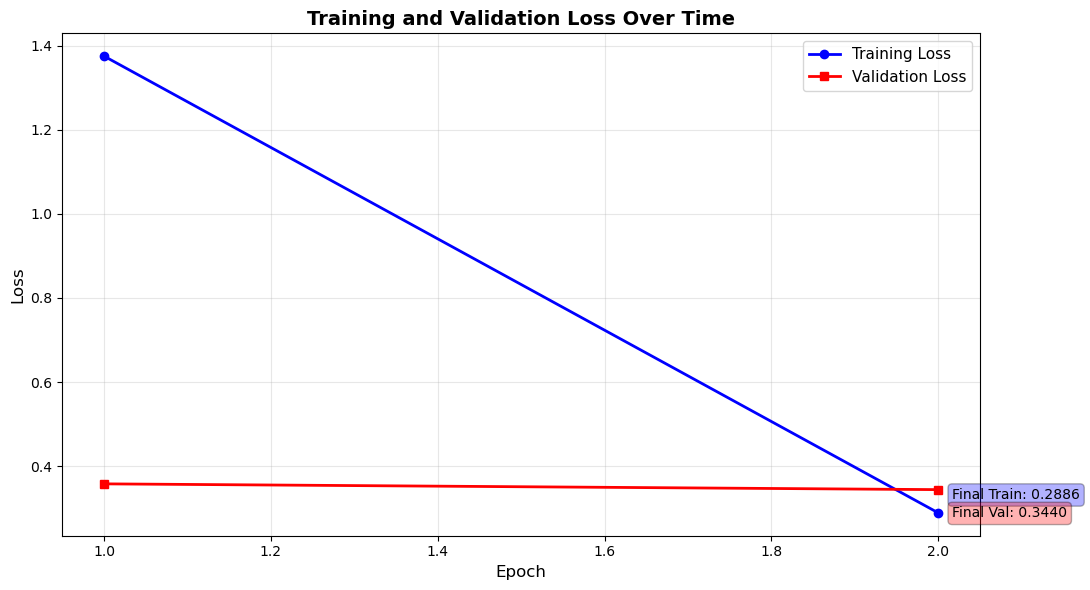


🎯 Training Analysis:
Training loss improvement: 1.0869
Validation loss improvement: 0.0137


In [30]:
# Extract training metrics from trainer state
train_losses = []
val_losses = []
epochs = []

print("📊 Extracting training metrics...")

# Parse through training log history
for log in trainer.state.log_history:
    if "epoch" in log:
        if "loss" in log and "eval_loss" not in log:
            # Training loss
            train_losses.append(log["loss"])
            epochs.append(log["epoch"])
        elif "eval_loss" in log:
            # Validation loss
            val_losses.append(log["eval_loss"])

# Display extracted metrics
print("📈 Training Metrics:")
print(f"Training losses: {train_losses}")
print(f"Validation losses: {val_losses}")
print(f"Epochs: {epochs}")

# Create loss visualization
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add text annotations for final values
if train_losses and val_losses:
    plt.annotate(f'Final Train: {train_losses[-1]:.4f}', 
                xy=(epochs[-1], train_losses[-1]), xytext=(10, 10),
                textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.3))
    plt.annotate(f'Final Val: {val_losses[-1]:.4f}', 
                xy=(len(val_losses), val_losses[-1]), xytext=(10, -20),
                textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))

plt.show()

# Analyze training results
print("\n🎯 Training Analysis:")
if len(train_losses) > 1:
    improvement = train_losses[0] - train_losses[-1]
    print(f"Training loss improvement: {improvement:.4f}")
if len(val_losses) > 1:
    val_improvement = val_losses[0] - val_losses[-1]
    print(f"Validation loss improvement: {val_improvement:.4f}")

## 💾 Saving the Fine-tuned Model

Saving both the model and tokenizer for future use:
- **Model weights**: Fine-tuned parameters
- **Tokenizer configuration**: Language mappings and vocabulary
- **Generation config**: Default inference parameters

In [31]:
# Save the fine-tuned model and tokenizer
model_save_path = 'mbart_one_to_many_2ep_full_finetuned_bidir'

print(f"💾 Saving fine-tuned model to: {model_save_path}")

# Save both model and tokenizer
# This automatically saves:
# - Model weights (pytorch_model.bin)
# - Model configuration (config.json)
# - Tokenizer files (tokenizer.json, special_tokens_map.json, etc.)
trainer.save_model(model_save_path)

print("✅ Model and tokenizer saved successfully!")
print(f"📁 Saved files in: {model_save_path}/")

# List saved files
import os
if os.path.exists(model_save_path):
    files = os.listdir(model_save_path)
    print("📋 Saved files:")
    for file in sorted(files):
        print(f"  - {file}")

💾 Saving fine-tuned model to: mbart_one_to_many_2ep_full_finetuned_bidir
✅ Model and tokenizer saved successfully!
📁 Saved files in: mbart_one_to_many_2ep_full_finetuned_bidir/
📋 Saved files:
  - config.json
  - generation_config.json
  - model.safetensors
  - sentencepiece.bpe.model
  - special_tokens_map.json
  - tokenizer_config.json
  - training_args.bin


## 🔄 Loading the Fine-tuned Model

Loading our saved model for inference and evaluation:
- **Model**: Fine-tuned mBART with improved Arabic-English translation
- **Tokenizer**: Configured with proper language mappings
- **Device**: Moving to GPU for faster inference

In [32]:
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

print("🔄 Loading fine-tuned model...")

# Load the fine-tuned model and tokenizer from saved directory
model = MBartForConditionalGeneration.from_pretrained(model_save_path)
tokenizer = MBart50Tokenizer.from_pretrained(model_save_path)

# Move model to appropriate device (GPU if available)
model.to(device)

print("✅ Fine-tuned model loaded successfully!")
print(f"🖥️ Model device: {next(model.parameters()).device}")
print(f"📊 Model parameters: {model.num_parameters():,}")

🔄 Loading fine-tuned model...
✅ Fine-tuned model loaded successfully!
🖥️ Model device: cuda:0
📊 Model parameters: 610,879,488


## 🧪 Post-Training Model Evaluation

Testing our fine-tuned model with the same examples used for pre-training evaluation:
- **Compare** performance before and after fine-tuning
- **Assess** translation quality improvements
- **Verify** bidirectional translation capabilities

In [35]:
# Test fine-tuned model: English → Arabic translation
sample_english = "The greater the burden, the more you must be charged with it by God. The greater the blessing He has bestowed upon you, the more you must be thankful"

print("🔄 Testing English → Arabic translation (fine-tuned):")
print(f"Input: {sample_english}")

# Set tokenizer source language to English
tokenizer.src_lang = "en_XX"

# Generate Arabic translation using fine-tuned model
with torch.no_grad():
    # Tokenize input text
    encoding = tokenizer(sample_english, return_tensors='pt')
    
    # 🔧 IMPORTANT: Move inputs to the same device as the model
    input_ids = encoding.input_ids.to(device)
    attention_mask = encoding.attention_mask.to(device)
    
    # Generate translation with forced Arabic output
    result = model.generate(
        input_ids=input_ids, 
        attention_mask=attention_mask,
        forced_bos_token_id=tokenizer.lang_code_to_id["ar_AR"],  # Force Arabic output
        max_length=512,
        num_beams=4,  # Beam search for better quality
        early_stopping=True
    )
    
    # Decode the generated tokens
    translation = tokenizer.batch_decode(result, skip_special_tokens=True)[0]

print(f"Translation: {translation}")

🔄 Testing English → Arabic translation (fine-tuned):
Input: The greater the burden, the more you must be charged with it by God. The greater the blessing He has bestowed upon you, the more you must be thankful
Translation: وكلما كان الثقل أعظم، كان عليك أن تكلفه أكثر من الله، وكلما كان النعمة التي أنجز عليك أعظم، كان عليك أن تشكر أكثر.


In [36]:
# Test fine-tuned model: Arabic → English translation
sample_arabic = "كلما زاد العبء، كلما كان عليك أن تتحمله من الله. كلما كانت البركة التي منحها لك أكبر، كلما كان عليك أن تكون أكثر امتنانًا"

print("🔄 Testing Arabic → English translation (fine-tuned):")
print(f"Input: {sample_arabic}")

# Set tokenizer source language to Arabic
tokenizer.src_lang = "ar_AR"

# Generate English translation using fine-tuned model
with torch.no_grad():
    # Tokenize input text
    encoding = tokenizer(sample_arabic, return_tensors='pt')
    
    # 🔧 IMPORTANT: Move inputs to the same device as the model
    input_ids = encoding.input_ids.to(device)
    attention_mask = encoding.attention_mask.to(device)
    
    # Generate translation with forced English output
    result = model.generate(
        input_ids=input_ids, 
        attention_mask=attention_mask,
        forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],  # Force English output
        max_length=512,
        num_beams=4,  # Beam search for better quality
        early_stopping=True
    )
    
    # Decode the generated tokens
    translation = tokenizer.batch_decode(result, skip_special_tokens=True)[0]

print(f"Translation: {translation}")

🔄 Testing Arabic → English translation (fine-tuned):
Input: كلما زاد العبء، كلما كان عليك أن تتحمله من الله. كلما كانت البركة التي منحها لك أكبر، كلما كان عليك أن تكون أكثر امتنانًا
Translation: However you increase the intellect, however you support him from God. However the fruits that give it to you are greater, however you become more solid, however you become more solid


## 📏 Quantitative Evaluation with BLEU Score

**BLEU (Bilingual Evaluation Understudy)** is a standard metric for evaluating translation quality:
- **Range**: 0-100 (higher is better)
- **Measurement**: N-gram overlap between predicted and reference translations
- **Comparison**: We'll compare pre-trained vs. fine-tuned model performance

### Evaluation Setup:
- **Test Set**: 500 English→Arabic pairs from our test data
- **Metrics**: BLEU-1, BLEU-2, BLEU-3, BLEU-4 scores
- **Models**: Original mBART vs. Fine-tuned mBART

In [37]:
# Load BLEU evaluation metric
bleu = evaluate.load('bleu')

print("📏 Setting up BLEU evaluation...")

# Load the original (untrained) model for comparison
print("🔄 Loading original mBART model for comparison...")
untrained_model = MBartForConditionalGeneration.from_pretrained('facebook/mbart-large-50-one-to-many-mmt')
untrained_model.to(device)

# Load original tokenizer
untrained_tokenizer = MBart50Tokenizer.from_pretrained('facebook/mbart-large-50-one-to-many-mmt')

print("✅ Original model and tokenizer loaded for comparison!")
print(f"🖥️ Untrained model device: {next(untrained_model.parameters()).device}")

📏 Setting up BLEU evaluation...
🔄 Loading original mBART model for comparison...
✅ Original model and tokenizer loaded for comparison!
🖥️ Untrained model device: cuda:0


## 🎯 Evaluation Data Preparation

For fair comparison, we'll split our test data into two groups:
- **English → Arabic**: 500 translation pairs
- **Arabic → English**: 500 translation pairs

This ensures balanced evaluation of both translation directions.

In [38]:
# Split test data for bidirectional evaluation
# This ensures we test both translation directions equally
en_to_ar_data = test_data.sample(frac=0.5, random_state=123)
ar_to_en_data = test_data.loc[test_data.index.difference(en_to_ar_data.index)]

print(f"📊 Evaluation Data Split:")
print(f"English → Arabic pairs: {len(en_to_ar_data)}")
print(f"Arabic → English pairs: {len(ar_to_en_data)}")
print(f"Total evaluation pairs: {len(en_to_ar_data) + len(ar_to_en_data)}")

# Display sample from each direction
print(f"\n📝 Sample English → Arabic:")
sample_en = en_to_ar_data.iloc[0]
print(f"EN: {sample_en['en']}")
print(f"AR: {sample_en['ar']}")

print(f"\n📝 Sample Arabic → English:")
sample_ar = ar_to_en_data.iloc[0]
print(f"AR: {sample_ar['ar']}")
print(f"EN: {sample_ar['en']}")

📊 Evaluation Data Split:
English → Arabic pairs: 500
Arabic → English pairs: 500
Total evaluation pairs: 1000

📝 Sample English → Arabic:
EN: What appears from these words is that the nerve exits in the first vertebra from above, and this was invalidated in his words in the first vertebra, and it is apparently invalidated by what he said in his words in the first vertebra.
AR: الذي يظهر من هذا الكلام أن مخرج العصب في الفقرة الأولى من فوق وهذا قد أبطله في كلامه في الفقرة الأولى وهو ظاهر البطلان بما قاله في كلامه في الفقرة الأولى.

📝 Sample Arabic → English:
AR: [كيفية الدخول على الملك] وإن كان دخوله عليه من الباب الأول الذي يقابل وجه الملك ويحاذيه - وكان له طريق عن يمينه أو شماله - عدل نحو الطريق الذي لا يقابله فيه بوجهه، ثم انحرف نحو مجلس الملك، فسلم قائما ملاحظا للملك.
EN: [How to enter upon the king] If he enters upon him from the first door that faces the king’s face and is parallel to him - and he has a path to his right or left - he turns towards the path that does not face him, t

## 🔄 English → Arabic Translation Evaluation

We'll process the English→Arabic test set in batches to:
1. **Generate translations** from both untrained and fine-tuned models
2. **Compare outputs** with reference Arabic translations
3. **Compute BLEU scores** for quantitative assessment

**Batch Processing**: Using batches of 16 for efficient GPU utilization

In [39]:
import math
from tqdm import tqdm

# Set batch size for efficient processing
batch_size = 16
num_batches = int(math.ceil(len(en_to_ar_data) / batch_size))

# Store all model outputs for BLEU computation
all_untrained_model_outputs = []
all_trained_model_outputs = []

print(f"🔄 Processing {len(en_to_ar_data)} English → Arabic translations...")
print(f"Using {num_batches} batches of size {batch_size}")

# Process data in batches
for i in tqdm(range(num_batches), desc="Generating translations"):
    
    # Define batch boundaries
    batch_start = i * batch_size
    batch_end = batch_start + batch_size
    
    # Get current batch (handle last batch which might be smaller)
    if i == num_batches - 1:
        batch_df = en_to_ar_data.iloc[batch_start:]
    else:
        batch_df = en_to_ar_data.iloc[batch_start:batch_end]
    
    # Prepare input prompts (English sentences)
    prompts = [f'{english}' for english in batch_df['en']]
    
    # Generate translations without gradient computation (inference mode)
    with torch.no_grad():
        
        # Set source language for both tokenizers (English input)
        tokenizer.src_lang = "en_XX"
        untrained_tokenizer.src_lang = "en_XX"
        
        # Tokenize input prompts
        encodings = tokenizer(
            prompts, 
            return_tensors="pt", 
            padding="max_length", 
            truncation=True, 
            max_length=256
        )
        
        # Move inputs to GPU
        input_ids = encodings.input_ids.to(device)
        attention_mask = encodings.attention_mask.to(device)
        
        # 🤖 Generate translations with UNTRAINED model
        untrained_outputs = untrained_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            forced_bos_token_id=untrained_tokenizer.lang_code_to_id["ar_AR"],  # Force Arabic output
            generation_config=GenerationConfig(
                max_new_tokens=256,
                num_beams=4,  # Beam search for better quality
                early_stopping=True,
                no_repeat_ngram_size=2  # Prevent repetition
            )
        )
        
        # Decode untrained model outputs
        untrained_text_outputs = untrained_tokenizer.batch_decode(
            untrained_outputs, 
            skip_special_tokens=True
        )
        all_untrained_model_outputs.extend(untrained_text_outputs)
        
        # 🎯 Generate translations with FINE-TUNED model
        trained_outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            forced_bos_token_id=tokenizer.lang_code_to_id["ar_AR"],  # Force Arabic output
            generation_config=GenerationConfig(
                max_new_tokens=256,
                num_beams=4,  # Beam search for better quality
                early_stopping=True,
                no_repeat_ngram_size=2  # Prevent repetition
            )
        )
        
        # Decode fine-tuned model outputs
        trained_text_outputs = tokenizer.batch_decode(
            trained_outputs, 
            skip_special_tokens=True
        )
        all_trained_model_outputs.extend(trained_text_outputs)

print(f"✅ Generated {len(all_untrained_model_outputs)} untrained translations")
print(f"✅ Generated {len(all_trained_model_outputs)} fine-tuned translations")

🔄 Processing 500 English → Arabic translations...
Using 32 batches of size 16


Generating translations: 100%|██████████████████████████████████████████████████████████| 32/32 [05:38<00:00, 10.56s/it]

✅ Generated 500 untrained translations
✅ Generated 500 fine-tuned translations


In [40]:
# Verify we have the correct number of translations
assert len(all_untrained_model_outputs) == len(en_to_ar_data), "Mismatch in untrained outputs"
assert len(all_trained_model_outputs) == len(en_to_ar_data), "Mismatch in trained outputs"

# Store translations in the dataframe for easy comparison
en_to_ar_data = en_to_ar_data.copy()  # Avoid SettingWithCopyWarning
en_to_ar_data['trained_model_arabic'] = all_trained_model_outputs
en_to_ar_data['untrained_model_arabic'] = all_untrained_model_outputs

print("📊 Translation Results Summary:")
print(f"Total English → Arabic translations: {len(en_to_ar_data)}")

# Display a few examples for qualitative assessment
print("\n📝 Sample Translation Comparison:")
for i in range(3):
    sample = en_to_ar_data.iloc[i]
    print(f"\nExample {i+1}:")
    print(f"🔤 English Input: {sample['en']}")
    print(f"🎯 Reference Arabic: {sample['ar']}")
    print(f"🤖 Untrained Model: {sample['untrained_model_arabic']}")
    print(f"🔥 Fine-tuned Model: {sample['trained_model_arabic']}")
    print("-" * 80)

📊 Translation Results Summary:
Total English → Arabic translations: 500

📝 Sample Translation Comparison:

Example 1:
🔤 English Input: What appears from these words is that the nerve exits in the first vertebra from above, and this was invalidated in his words in the first vertebra, and it is apparently invalidated by what he said in his words in the first vertebra.
🎯 Reference Arabic: الذي يظهر من هذا الكلام أن مخرج العصب في الفقرة الأولى من فوق وهذا قد أبطله في كلامه في الفقرة الأولى وهو ظاهر البطلان بما قاله في كلامه في الفقرة الأولى.
🤖 Untrained Model: ما يظهر من هذه الكلمات هو أن الاعصاب تخرج من العمود الفقري الأول من الأعلى، وقد كان هذا غير صالحاً في كلماته في الجذع الأول، ومن الواضح أنه غير صحيح بما قاله من خلال كلماتها في الرّمنة الأولى.
🔥 Fine-tuned Model: وما يظهر من هذه الألفاظ أن العصب يخرج من الفقرة الأولى من فوق، وهذا باطل في كلامه من الفقار الأول، وهو ظاهرا باطل بما قال به من قوله من جملته من الجذع الأول.
------------------------------------------------------------------

## 📊 BLEU Score Computation

Computing BLEU scores to quantitatively compare translation quality:
- **BLEU-1, BLEU-2, BLEU-3, BLEU-4**: Different n-gram precision scores
- **Higher scores**: Better translation quality
- **Comparison**: Untrained vs. Fine-tuned model performance

### BLEU Score Interpretation:
- **0-10**: Very poor quality
- **10-20**: Poor quality  
- **20-30**: Reasonable quality
- **30-40**: Good quality
- **40+**: Excellent quality

In [41]:
# Prepare data for BLEU evaluation
print("📊 Computing BLEU scores for English → Arabic translation...")

# Extract predictions and references
predictions_untrained = en_to_ar_data['untrained_model_arabic'].tolist()
predictions_trained = en_to_ar_data['trained_model_arabic'].tolist()
references_raw = en_to_ar_data['ar'].tolist()

# Format references for BLEU computation (each reference needs to be in a list)
references = [[ref] for ref in references_raw]

# Ensure all data is in string format (required by BLEU metric)
predictions_untrained = [str(pred) for pred in predictions_untrained]
predictions_trained = [str(pred) for pred in predictions_trained]
references = [[str(ref)] for ref in references_raw]

print(f"📏 Computing BLEU for {len(predictions_untrained)} translation pairs...")

# Compute BLEU scores for untrained model
original_bleu = bleu.compute(
    predictions=predictions_untrained,
    references=references,
)

# Compute BLEU scores for fine-tuned model
trained_bleu = bleu.compute(
    predictions=predictions_trained,
    references=references,
)

print("✅ BLEU computation completed!")

📊 Computing BLEU scores for English → Arabic translation...
📏 Computing BLEU for 500 translation pairs...
✅ BLEU computation completed!


## 📈 English → Arabic BLEU Results

Comparing the translation quality between pre-trained and fine-tuned models:

In [42]:
print('🔄 English → Arabic Translation Results')
print('=' * 50)

print('\n🤖 Original (Pre-trained) Model BLEU Scores:')
print(json.dumps(original_bleu, indent=2))

print('\n🔥 Fine-tuned Model BLEU Scores:')
print(json.dumps(trained_bleu, indent=2))

# Calculate improvement
bleu_improvement = trained_bleu['bleu'] - original_bleu['bleu']
print(f'\n📈 BLEU Score Improvement:')
print(f'Original BLEU: {original_bleu["bleu"]:.4f}')
print(f'Fine-tuned BLEU: {trained_bleu["bleu"]:.4f}')
print(f'Improvement: +{bleu_improvement:.4f} ({bleu_improvement/original_bleu["bleu"]*100:.1f}%)')

# Individual n-gram improvements
print(f'\n📊 Detailed N-gram Improvements:')
for i, (orig, trained) in enumerate(zip(original_bleu['precisions'], trained_bleu['precisions'])):
    improvement = trained - orig
    print(f'BLEU-{i+1}: {orig:.4f} → {trained:.4f} (+{improvement:.4f})')

🔄 English → Arabic Translation Results

🤖 Original (Pre-trained) Model BLEU Scores:
{
  "bleu": 0.04095130155220747,
  "precisions": [
    0.27650206597575017,
    0.07137348383930449,
    0.02172491462617162,
    0.006559601900022619
  ],
  "brevity_penalty": 1.0,
  "length_ratio": 1.129706152433425,
  "translation_length": 14763,
  "reference_length": 13068
}

🔥 Fine-tuned Model BLEU Scores:
{
  "bleu": 0.1251646739834074,
  "precisions": [
    0.4462803320561941,
    0.18548387096774194,
    0.08501040943789036,
    0.04143997098295248
  ],
  "brevity_penalty": 0.9578123009106891,
  "length_ratio": 0.9586776859504132,
  "translation_length": 12528,
  "reference_length": 13068
}

📈 BLEU Score Improvement:
Original BLEU: 0.0410
Fine-tuned BLEU: 0.1252
Improvement: +0.0842 (205.6%)

📊 Detailed N-gram Improvements:
BLEU-1: 0.2765 → 0.4463 (+0.1698)
BLEU-2: 0.0714 → 0.1855 (+0.1141)
BLEU-3: 0.0217 → 0.0850 (+0.0633)
BLEU-4: 0.0066 → 0.0414 (+0.0349)


## 🔄 Arabic → English Translation Evaluation

Now evaluating the reverse direction to assess bidirectional translation capabilities:
- **Input**: Arabic sentences from our test set
- **Output**: English translations
- **Comparison**: Both models' English generation quality

In [43]:
# Reset output lists for Arabic → English evaluation
all_untrained_ar_to_en = []
all_trained_ar_to_en = []

# Calculate batches for Arabic → English data
ar_batch_size = 16
ar_num_batches = int(math.ceil(len(ar_to_en_data) / ar_batch_size))

print(f"🔄 Processing {len(ar_to_en_data)} Arabic → English translations...")
print(f"Using {ar_num_batches} batches of size {ar_batch_size}")

# Process Arabic → English translations in batches
for i in tqdm(range(ar_num_batches), desc="Generating Arabic→English"):
    
    # Define batch boundaries
    batch_start = i * ar_batch_size
    batch_end = batch_start + ar_batch_size
    
    # Get current batch
    if i == ar_num_batches - 1:
        batch_df = ar_to_en_data.iloc[batch_start:]
    else:
        batch_df = ar_to_en_data.iloc[batch_start:batch_end]
    
    # Prepare Arabic input prompts
    arabic_prompts = [f'{arabic}' for arabic in batch_df['ar']]
    
    # Generate translations without gradient computation
    with torch.no_grad():
        
        # Set source language to Arabic for both tokenizers
        tokenizer.src_lang = "ar_AR"
        untrained_tokenizer.src_lang = "ar_AR"
        
        # Tokenize Arabic input
        encodings = tokenizer(
            arabic_prompts, 
            return_tensors="pt", 
            padding="max_length", 
            truncation=True, 
            max_length=256
        )
        
        # Move to GPU
        input_ids = encodings.input_ids.to(device)
        attention_mask = encodings.attention_mask.to(device)
        
        # Generate English translations with UNTRAINED model
        untrained_ar_outputs = untrained_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            forced_bos_token_id=untrained_tokenizer.lang_code_to_id["en_XX"],  # Force English output
            generation_config=GenerationConfig(
                max_new_tokens=256,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2
            )
        )
        
        # Decode untrained model outputs
        untrained_ar_text = untrained_tokenizer.batch_decode(
            untrained_ar_outputs, 
            skip_special_tokens=True
        )
        all_untrained_ar_to_en.extend(untrained_ar_text)
        
        # Generate English translations with FINE-TUNED model
        trained_ar_outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],  # Force English output
            generation_config=GenerationConfig(
                max_new_tokens=256,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2
            )
        )
        
        # Decode fine-tuned model outputs
        trained_ar_text = tokenizer.batch_decode(
            trained_ar_outputs, 
            skip_special_tokens=True
        )
        all_trained_ar_to_en.extend(trained_ar_text)

print(f"✅ Generated {len(all_untrained_ar_to_en)} untrained Arabic→English translations")
print(f"✅ Generated {len(all_trained_ar_to_en)} fine-tuned Arabic→English translations")

🔄 Processing 500 Arabic → English translations...
Using 32 batches of size 16


Generating Arabic→English: 100%|████████████████████████████████████████████████████████| 32/32 [04:02<00:00,  7.58s/it]

✅ Generated 500 untrained Arabic→English translations
✅ Generated 500 fine-tuned Arabic→English translations


In [44]:
# Store Arabic → English translations
ar_to_en_data = ar_to_en_data.copy()
ar_to_en_data['trained_model_english'] = all_trained_ar_to_en
ar_to_en_data['untrained_model_english'] = all_untrained_ar_to_en

# Prepare data for BLEU evaluation (Arabic → English)
print("📊 Computing BLEU scores for Arabic → English translation...")

ar_predictions_untrained = ar_to_en_data['untrained_model_english'].tolist()
ar_predictions_trained = ar_to_en_data['trained_model_english'].tolist()
ar_references_raw = ar_to_en_data['en'].tolist()

# Format for BLEU computation
ar_references = [[ref] for ref in ar_references_raw]
ar_predictions_untrained = [str(pred) for pred in ar_predictions_untrained]
ar_predictions_trained = [str(pred) for pred in ar_predictions_trained]
ar_references = [[str(ref)] for ref in ar_references_raw]

# Compute BLEU scores
ar_original_bleu = bleu.compute(
    predictions=ar_predictions_untrained,
    references=ar_references,
)

ar_trained_bleu = bleu.compute(
    predictions=ar_predictions_trained,
    references=ar_references,
)

print("✅ Arabic → English BLEU computation completed!")

📊 Computing BLEU scores for Arabic → English translation...
✅ Arabic → English BLEU computation completed!


## 🎯 Complete Bidirectional Translation Results

Final comparison of our fine-tuning results across both translation directions:

In [45]:
print('🌍 COMPLETE BIDIRECTIONAL TRANSLATION EVALUATION')
print('=' * 60)

print('\n📊 ENGLISH → ARABIC RESULTS:')
print('-' * 30)
print('🤖 Original Model:')
print(json.dumps(original_bleu, indent=2))
print('\n🔥 Fine-tuned Model:')
print(json.dumps(trained_bleu, indent=2))

en_ar_improvement = trained_bleu['bleu'] - original_bleu['bleu']
print(f'\n📈 EN→AR Improvement: +{en_ar_improvement:.4f} ({en_ar_improvement/original_bleu["bleu"]*100:.1f}%)')

print('\n📊 ARABIC → ENGLISH RESULTS:')
print('-' * 30)
print('🤖 Original Model:')
print(json.dumps(ar_original_bleu, indent=2))
print('\n🔥 Fine-tuned Model:')
print(json.dumps(ar_trained_bleu, indent=2))

ar_en_improvement = ar_trained_bleu['bleu'] - ar_original_bleu['bleu']
print(f'\n📈 AR→EN Improvement: +{ar_en_improvement:.4f} ({ar_en_improvement/ar_original_bleu["bleu"]*100:.1f}%)')

print('\n🏆 OVERALL SUMMARY:')
print('=' * 30)
print(f'📊 Average Original BLEU: {(original_bleu["bleu"] + ar_original_bleu["bleu"])/2:.4f}')
print(f'🔥 Average Fine-tuned BLEU: {(trained_bleu["bleu"] + ar_trained_bleu["bleu"])/2:.4f}')
avg_improvement = (en_ar_improvement + ar_en_improvement) / 2
print(f'📈 Average Improvement: +{avg_improvement:.4f}')

# Qualitative examples
print('\n📝 SAMPLE TRANSLATION COMPARISON:')
print('=' * 40)

print('\n🔤 English → Arabic Example:')
sample_en = en_to_ar_data.iloc[0]
print(f"Input: {sample_en['en']}")
print(f"Reference: {sample_en['ar']}")
print(f"Pre-trained: {sample_en['untrained_model_arabic']}")
print(f"Fine-tuned: {sample_en['trained_model_arabic']}")

print('\n🔤 Arabic → English Example:')
sample_ar = ar_to_en_data.iloc[0]
print(f"Input: {sample_ar['ar']}")
print(f"Reference: {sample_ar['en']}")
print(f"Pre-trained: {sample_ar['untrained_model_english']}")
print(f"Fine-tuned: {sample_ar['trained_model_english']}")

🌍 COMPLETE BIDIRECTIONAL TRANSLATION EVALUATION

📊 ENGLISH → ARABIC RESULTS:
------------------------------
🤖 Original Model:
{
  "bleu": 0.04095130155220747,
  "precisions": [
    0.27650206597575017,
    0.07137348383930449,
    0.02172491462617162,
    0.006559601900022619
  ],
  "brevity_penalty": 1.0,
  "length_ratio": 1.129706152433425,
  "translation_length": 14763,
  "reference_length": 13068
}

🔥 Fine-tuned Model:
{
  "bleu": 0.1251646739834074,
  "precisions": [
    0.4462803320561941,
    0.18548387096774194,
    0.08501040943789036,
    0.04143997098295248
  ],
  "brevity_penalty": 0.9578123009106891,
  "length_ratio": 0.9586776859504132,
  "translation_length": 12528,
  "reference_length": 13068
}

📈 EN→AR Improvement: +0.0842 (205.6%)

📊 ARABIC → ENGLISH RESULTS:
------------------------------
🤖 Original Model:
{
  "bleu": 0.0017288444268053257,
  "precisions": [
    0.13921317767471614,
    0.004247876061969015,
    0.0007822005909960021,
    0.0002725538293813028
  ],
 

## 🔹 Exercise: Advanced Fine-tuning Experiments

### 📝 Suggested Improvements to Try:

1. **Increase Training Data**: 
   - Use the full dataset (not just 5K samples)
   - Observe how performance scales with data size

2. **Hyperparameter Tuning**:
   - Try different learning rates (1e-5, 2e-5, 1e-4)
   - Experiment with different batch sizes
   - Adjust the number of training epochs

3. **Advanced Generation Parameters**:
   - Experiment with different beam sizes (2, 6, 8)
   - Try temperature sampling vs beam search
   - Test different max_length values

4. **Data Augmentation**:
   - Add noise to input text
   - Try back-translation augmentation
   - Experiment with different prompting strategies

5. **Evaluation Metrics**:
   - Implement ROUGE scores
   - Add METEOR evaluation
   - Try BERTScore for semantic similarity

### 📊 Questions to Explore:
- How does the model perform on longer sentences?
- What types of sentences show the most improvement?
- Does the model maintain consistency across different domains?

### Contributed by: Ali Habibullah